# **Module 3: Introduction to Deep Learning with PyTorch**

## Introduction
In previous notebooks, we have created, trained, and evaluated neural networks using python classes we have developed. There are many open source libraries that help optimize and make the process of creating these models repeatable, and we will look at one of the most popular ones in this notebook: PyTorch.

Now the we know the basics of using tensors in [Pytorch](https://pytorch.org/) from the previous notebook, we will use them to create Deep Learning models. In the following notebook we will go through an example of creating both a classification and regression model in Pytorch on a large publicly available dataset.

## Classification with PyTorch

In this first example, we will be using PyTorch to perform a binary classification task on an open source dataset. The dataset in particular is the Abalone Age Dataset and can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/).

[Abalone](https://en.wikipedia.org/wiki/Abalone) are a type of marine snail, and their age can be determined by performing an extremely manual task of counting rings inside of their shell. This dataset contains a number of measurements that can be used to predict the number of rings.

### Datset Download and Module Import

In [ ]:
# Download the abalone .csv files from data archive if needed
!rm abalone.data abalone.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

rm: cannot remove 'abalone.data': No such file or directory
rm: cannot remove 'abalone.names': No such file or directory
--2022-08-31 14:45:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: ‘abalone.data’

abalone.data        100%[===================>] 187.38K   733KB/s    in 0.3s    

2022-08-31 14:45:05 (733 KB/s) - ‘abalone.data’ saved [191873/191873]

--2022-08-31 14:45:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [applicat

In [ ]:
# As you can see we now require a lot of different modules
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time, copy

### Prepare the abalone data for classification

We want to create a classification problem to differentiate old and young abalones. We designate any abalone with less than 10 rings as young, and all others as old.

In [ ]:

column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight",
                "Shucked weight", "Viscera weight", "Shell weights", "Rings"]
df = pd.read_csv('abalone.data', header=None, names=column_names)
df['Old'] = 0  # By default, abalone is Young
df.loc[(df['Rings'] >= 10), 'Old'] = 1 # 10 rings or more means an Abalone is old
class_labels = ['Young', 'Old']   # [0, 1], [N, P]
numerical_feature_columns = column_names[1:5] # We first only want to classify with numerical features excluding sex and only the whole weight
print(numerical_feature_columns)
label_column = 'Old'


df.head() # Visualize a subset of the dataset

['Length', 'Diameter', 'Height', 'Whole weight']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


### Train-Validation-Test Split and Standardization

For this classification task, we will split our dataset into 3 different subsets as described earlier in the module. The train subset will be the largest and this is the subset is used to train and optimize the weights of the model. Next is the validation subset, which will be used as an unbiased evaluation of the model and help to tune different hyperparameters. Lastly is the test subset, which is used to perform an unbiased evaluation of the fully trained model.

Additionally, we would like to perform data standardization by removing the mean and scaling by the variance. We will perform this on each of the features however we want to ensure that this standardization function is computed on the train data subset. We then apply the standardization function to the validation and test datasets. By ensuring that the standardization is only computed on the train subset, we gaurantee that no information from the validation or test datasets is leaking into the train subset.

Below we provide a function for splitting a given dataset into a 60-20-20 train-validation-test and performing data standardization using the sklearn StandardScaler class for PyTorch consumption:

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def train_test_val_split(df, feature_columns, label_column, ct):
  # First perform an 80/20 train/test split
  initial_train_split = df.sample(frac=.8,random_state=42)
  test = df.drop(initial_train_split.index)

  # Next perform a 75/25 train/val split
  train = initial_train_split.sample(frac=.75, random_state=42)
  val = initial_train_split.drop(train.index)

  # Split all of the datasets into features and labels (x and y)
  train_x = train[feature_columns]
  # We won't be transforming the labels so they can go straight to torch tensors
  train_y = torch.from_numpy(train[label_column].values)

  val_x = val[feature_columns]
  val_y = torch.from_numpy(val[label_column].values)

  test_x = test[feature_columns]
  test_y = torch.from_numpy(test[label_column].values)

  # Fit our ColumnTransformer to the train dataset
  ct.fit(train_x)

  # Perform the standardization on each of the x datasets
  train_x = ct.transform(train_x)
  val_x = ct.transform(val_x)
  test_x = ct.transform(test_x)

  # Transform our datasets into Torch Tensors
  train_x = torch.from_numpy(train_x).float()
  val_x = torch.from_numpy(val_x).float()
  test_x = torch.from_numpy(test_x).float()

  # Create the input-label pair datasets to be consumed by PyTorch
  train_dataset = TensorDataset(train_x, train_y)
  test_dataset = TensorDataset(test_x, test_y)
  val_dataset = TensorDataset(val_x, val_y)
  return train_dataset, test_dataset, val_dataset


In [ ]:
# Create our StandardScaler to use for datastandardization
# More here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

train_dataset, test_dataset, val_dataset = train_test_val_split(df, numerical_feature_columns, label_column, ct)

### Model Hyperparameters and Definition
Now that we can easily split our dataset into train, validation, and test subsets, we turn to the selection of our hyperparameters. These hyperparameters include model architecture decisions (number of hidden layers) and external training parameters such as batch size, learning rate, and number of training epochs.

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

# model architecture
input_size = len(numerical_feature_columns) # Make sure to remove the index column
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50


### Hyperparameter Selection

In this walkthrough, we will use our validation set to determine two different hyperparameters.

The first is the total number of Epochs to train for. At the end of our entire training process we will select the weights from the epoch with the highest validation accuracy.

The second is number of layers - we will try both a 2-hidden-layer and 3-hidden-layer network. Again, which ever has the best performance on the validation set will be our final model of choice.

In [ ]:
# Simple two-hidden-layer classification model
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Simple three-hidden-layer classification model
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Final Data Preparation

Now that we have our model and our hyperparameters defined, we can do the last data preparation step. We will use a built in PyTorch class called a DataLoader with our batch size specified earlier. This DataLoader will be responsible for feeding in the batches of data to the model during training.

In [ ]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size),
               'val': DataLoader(val_dataset, batch_size=batch_size),
               'test': DataLoader(test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


### Training the model

Now that we have our model architecture defined and our data ready for consumption, we must define the training function. This function will be responsible for updating all of the weights of the model.

In [ ]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

We have written our training function above to be architecture independent. That means we can use the same function to train both the two-hidden-layer and three-hidden-layer networks.

In [ ]:
# Two-hidden-Layer Training
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
two_layer_model, training_curves_two_layer = train_model(two_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5318 Acc: 0.7362
val   Loss: 0.4655 Acc: 0.7823
test  Loss: 0.5285 Acc: 0.7174

Epoch 2/50
----------
train Loss: 0.5195 Acc: 0.7370
val   Loss: 0.4616 Acc: 0.7799
test  Loss: 0.5266 Acc: 0.7114

Epoch 3/50
----------
train Loss: 0.5145 Acc: 0.7406
val   Loss: 0.4588 Acc: 0.7787
test  Loss: 0.5256 Acc: 0.7150

Epoch 4/50
----------
train Loss: 0.5102 Acc: 0.7422
val   Loss: 0.4572 Acc: 0.7811
test  Loss: 0.5250 Acc: 0.7162

Epoch 5/50
----------
train Loss: 0.5082 Acc: 0.7446
val   Loss: 0.4558 Acc: 0.7811
test  Loss: 0.5247 Acc: 0.7114

Epoch 6/50
----------
train Loss: 0.5064 Acc: 0.7470
val   Loss: 0.4549 Acc: 0.7799
test  Loss: 0.5243 Acc: 0.7078

Epoch 7/50
----------
train Loss: 0.5050 Acc: 0.7498
val   Loss: 0.4539 Acc: 0.7823
test  Loss: 0.5240 Acc: 0.7114

Epoch 8/50
----------
train Loss: 0.5035 Acc: 0.7494
val   Loss: 0.4531 Acc: 0.7847
test  Loss: 0.5238 Acc: 0.7114

Epoch 9/50
----------
train Loss: 0.5023 Acc: 0.7506
val   Loss: 0.4529

In order to determine which weight we would like to use for our final model, we will look for the Epoch that performed best on the validation set.

In [ ]:
# Three-hidden-Layer Training
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5407 Acc: 0.7374
val   Loss: 0.4605 Acc: 0.7679
test  Loss: 0.5323 Acc: 0.7210

Epoch 2/50
----------
train Loss: 0.5214 Acc: 0.7418
val   Loss: 0.4550 Acc: 0.7775
test  Loss: 0.5288 Acc: 0.7198

Epoch 3/50
----------
train Loss: 0.5157 Acc: 0.7450
val   Loss: 0.4512 Acc: 0.7823
test  Loss: 0.5276 Acc: 0.7198

Epoch 4/50
----------
train Loss: 0.5089 Acc: 0.7466
val   Loss: 0.4493 Acc: 0.7835
test  Loss: 0.5266 Acc: 0.7210

Epoch 5/50
----------
train Loss: 0.5065 Acc: 0.7466
val   Loss: 0.4484 Acc: 0.7883
test  Loss: 0.5255 Acc: 0.7246

Epoch 6/50
----------
train Loss: 0.5046 Acc: 0.7510
val   Loss: 0.4469 Acc: 0.7883
test  Loss: 0.5254 Acc: 0.7246

Epoch 7/50
----------
train Loss: 0.5032 Acc: 0.7546
val   Loss: 0.4468 Acc: 0.7895
test  Loss: 0.5246 Acc: 0.7246

Epoch 8/50
----------
train Loss: 0.5018 Acc: 0.7522
val   Loss: 0.4468 Acc: 0.7919
test  Loss: 0.5244 Acc: 0.7222

Epoch 9/50
----------
train Loss: 0.5009 Acc: 0.7538
val   Loss: 0.4468

After our training, we saw comparable accuracy between our two different models so we will use the three-layer model going forward but will explore other methods of improving our performance.

### Training Curves and Metrics

Below we have provided functions for visualizing the training curves and metrics for the classification problem. Feel free to use these functions in the future!

In [ ]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_regression(model, device, dataloader):
    preds, targets = regress_predictions(model, device, dataloader)
    plt.figure()
    plt.title(f'Regression results')
    plt.scatter(targets, preds)
    xmin = min(min(targets), min(preds))
    xmax = max(max(targets), max(targets))
    plt.plot([xmin, xmax], [xmin, xmax], 'black', linestyle='--', marker='')
    plt.xlabel('target value')
    plt.ylabel('prediced value')

def regress_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_targets = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        all_targets = torch.cat((all_targets, targets), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_targets.detach().cpu()

def plot_metrics(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, preds)

    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    ind = np.argmin(np.abs(thresholds - 0.5))
    ax = disp.plot().ax_
    ax.scatter(fpr[ind], tpr[ind], color = 'red')
    ax.set_title('ROC Curve (red dot at threshold = 0.5)')

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    #disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

    ncm = metrics.confusion_matrix(labels, preds, normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=ncm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- rates')

    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    N, P = TN + FP, TP + FN
    ACC = (TP + TN)/(P+N)
    TPR, FPR, FNR, TNR = TP/P, FP/N, FN/P, TN/N
    print(f'\nAt default threshold:')
    print(f' TN = {TN:5},  FP = {FP:5} -> N = {N:5}')
    print(f' FN = {FN:5},  TP = {TP:5} -> P = {P:5}')
    print(f'TNR = {TNR:5.3f}, FPR = {FPR:5.3f}')
    print(f'FNR = {FNR:5.3f}, TPR = {TPR:5.3f}')
    print(f'ACC = {ACC:6.3f}')

    return cm, fpr, tpr, thresholds, auc

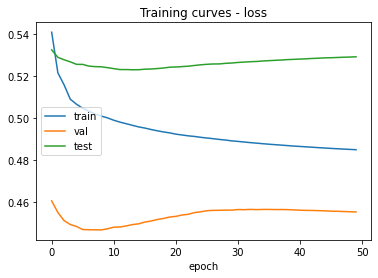

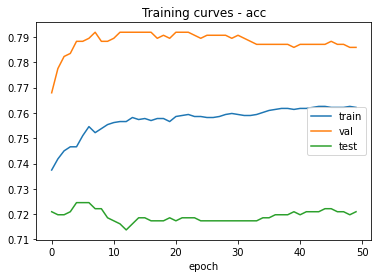

In [ ]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

Looking at this graph, we can see that our model is currently overfitting to the training dataset. As our blue training loss curve is steadily decreasing, we actually see that the validation loss increases. We will tackle the overfitting problem in the next sections!

In [ ]:
res = plot_metrics(three_layer_model, device, dataloaders, phase='test')

RuntimeError: ignored

Here we can see the ROC curve and confusion matrix that was discussed in the module. It looks like our model is incorrectly predicting Young Abalone as Old Abalone at a higher rate then vice-versa.

## Additional Features
For the first round of feature selection, we chose to only use numerical features. However, we are losing some critical information about the abalone by not including their sex in our model. In order to translate this ternary feature from our dataset into the model, we will use what is called a one hot encoding. We will now create one feature for each of the different options and assign a value of 1 if the sample is a member of that class, and 0 for the others. Encoding strategies can be simple such as this one hot method or can be much more complex as we will learn later in the course.

In [ ]:
# Insert the new one hot encoding features
encoded_df = df.copy(True)
encoded_df.insert(1, 'M', 0)
encoded_df.insert(1, 'F', 0)
encoded_df.insert(1, 'I', 0)
encoded_df.loc[(df['Sex'] == 'M'), 'M'] = 1
encoded_df.loc[(df['Sex'] == 'F'), 'F'] = 1
encoded_df.loc[(df['Sex'] == 'I'), 'I'] = 1
encoded_column_names = column_names[:]
encoded_column_names.insert(1,"M")
encoded_column_names.insert(1,"F")
encoded_column_names.insert(1,"I")
encoded_df.head()

,Sex,I,F,M,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,1,0,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


In [ ]:
encoded_feature_columns = encoded_column_names[1:8]
print(encoded_feature_columns)
label_column = 'Old'

df.head()

['I', 'F', 'M', 'Length', 'Diameter', 'Height', 'Whole weight']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


### Train-Validation-Test Split and Standardization

Again we want to perform a Train-Validation-Test split on our dataset. However, we want to make sure that we don't perform standardization on our new features that are one-hot encodings!

In [ ]:
# Here we will use the ColumnTransformer to perform datastandardization again. However we are only performing this standardization on the numerical features,
# NOT the one hot encoded features, so we specify that in the constructor of the ColumnTransformer.
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

encoded_train_dataset, encoded_test_dataset, encoded_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, label_column, ct)

### Model Hyperparameters and Definition

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

input_size = len(encoded_feature_columns) # make sure our input size includes the new features
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50


In [ ]:
three_layer_encoded_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_encoded_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Final Data Preparation

In [ ]:
# Set up pytorch Datasets and DataLoaders

dataloaders = {'train': DataLoader(encoded_train_dataset, batch_size=batch_size),
               'val': DataLoader(encoded_val_dataset, batch_size=batch_size),
               'test': DataLoader(encoded_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(encoded_train_dataset),
                 'val': len(encoded_val_dataset),
                 'test': len(encoded_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_layer_encoded_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_model, training_curves_three_layer_encoded = train_model(three_layer_encoded_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5322 Acc: 0.7306
val   Loss: 0.4440 Acc: 0.7859
test  Loss: 0.5125 Acc: 0.7305

Epoch 2/50
----------
train Loss: 0.5052 Acc: 0.7422
val   Loss: 0.4396 Acc: 0.7907
test  Loss: 0.5072 Acc: 0.7281

Epoch 3/50
----------
train Loss: 0.4990 Acc: 0.7470
val   Loss: 0.4391 Acc: 0.7859
test  Loss: 0.5054 Acc: 0.7210

Epoch 4/50
----------
train Loss: 0.4929 Acc: 0.7462
val   Loss: 0.4360 Acc: 0.7931
test  Loss: 0.5040 Acc: 0.7234

Epoch 5/50
----------
train Loss: 0.4906 Acc: 0.7454
val   Loss: 0.4357 Acc: 0.7955
test  Loss: 0.5038 Acc: 0.7246

Epoch 6/50
----------
train Loss: 0.4885 Acc: 0.7446
val   Loss: 0.4353 Acc: 0.7955
test  Loss: 0.5040 Acc: 0.7257

Epoch 7/50
----------
train Loss: 0.4869 Acc: 0.7466
val   Loss: 0.4350 Acc: 0.7967
test  Loss: 0.5039 Acc: 0.7234

Epoch 8/50
----------
train Loss: 0.4852 Acc: 0.7466
val   Loss: 0.4347 Acc: 0.8002
test  Loss: 0.5043 Acc: 0.7257

Epoch 9/50
----------
train Loss: 0.4839 Acc: 0.7474
val   Loss: 0.4348

By including these new features we actually see little change in our overall performance which indicates that these new features are not offering a significant information gain.

### Training Curves and Metrics

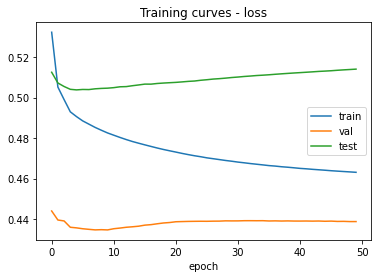

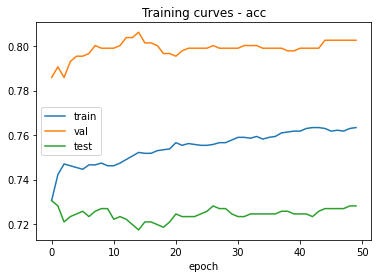

In [ ]:
plot_training_curves(training_curves_three_layer_encoded, phases=['train', 'val', 'test'])

Additionally, it looks like our model is still overfitting to the dataset based on these graphs.


At default threshold:
 TN =   259,  FP =   142 -> N =   401
 FN =    94,  TP =   340 -> P =   434
TNR = 0.646, FPR = 0.354
FNR = 0.217, TPR = 0.783
ACC =  0.717


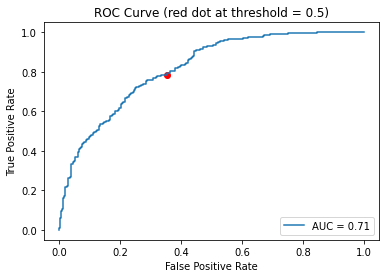

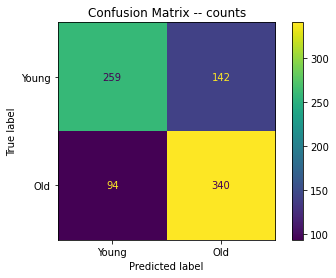

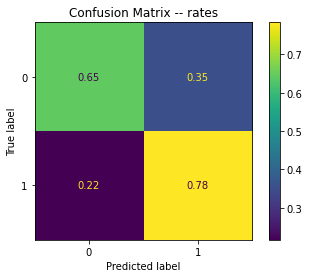

In [ ]:
res = plot_metrics(three_layer_encoded_model, device, dataloaders, phase='test')

## Regularization and Dropout

One of the key things we talked about in this module were methods to avoid overfitting. Looking at the training graphs above, we can see that the model significantly overfit to the training dataset. In order to combat this, we have a few tools at our disposal.

PyTorch has two of the methods we discussed, Regularization and Dropout built in! We will examine how both of these affects the performance of the model.

### Regularization

In [ ]:
# Reset the model
three_layer_encoded_l2_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes).to(device)
print(three_layer_encoded_l2_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_encoded_l2_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_model, training_curves_three_layer_encoded_l2 = train_model(three_layer_encoded_l2_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5367 Acc: 0.7330
val   Loss: 0.4566 Acc: 0.7787
test  Loss: 0.5196 Acc: 0.7281

Epoch 2/50
----------
train Loss: 0.5135 Acc: 0.7410
val   Loss: 0.4544 Acc: 0.7823
test  Loss: 0.5168 Acc: 0.7246

Epoch 3/50
----------
train Loss: 0.5111 Acc: 0.7434
val   Loss: 0.4543 Acc: 0.7823
test  Loss: 0.5163 Acc: 0.7269

Epoch 4/50
----------
train Loss: 0.5098 Acc: 0.7438
val   Loss: 0.4544 Acc: 0.7835
test  Loss: 0.5162 Acc: 0.7269

Epoch 5/50
----------
train Loss: 0.5089 Acc: 0.7454
val   Loss: 0.4546 Acc: 0.7895
test  Loss: 0.5159 Acc: 0.7281

Epoch 6/50
----------
train Loss: 0.5082 Acc: 0.7454
val   Loss: 0.4549 Acc: 0.7907
test  Loss: 0.5158 Acc: 0.7269

Epoch 7/50
----------
train Loss: 0.5076 Acc: 0.7462
val   Loss: 0.4552 Acc: 0.7907
test  Loss: 0.5158 Acc: 0.7257

Epoch 8/50
----------
train Loss: 0.5071 Acc: 0.7466
val   Loss: 0.4552 Acc: 0.7931
test  Loss: 0.5156 Acc: 0.7293

Epoch 9/50
----------
train Loss: 0.5066 Acc: 0.7474
val   Loss: 0.4553

#### Training Curves and Metrics

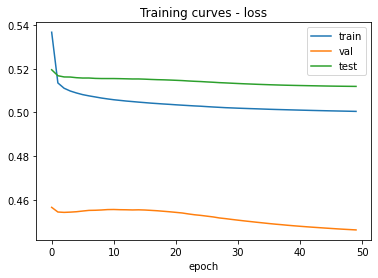

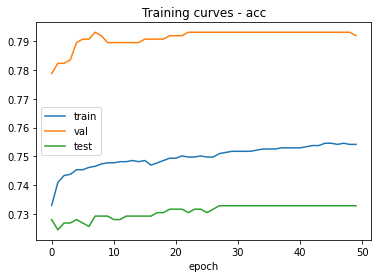

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2, phases=['train', 'val', 'test'])

Looking at the graphs above we do not see the same overfitting behavior to the validation set, however there are still other methods we can use to improve generalization even further.


At default threshold:
 TN =   249,  FP =   152 -> N =   401
 FN =    74,  TP =   360 -> P =   434
TNR = 0.621, FPR = 0.379
FNR = 0.171, TPR = 0.829
ACC =  0.729


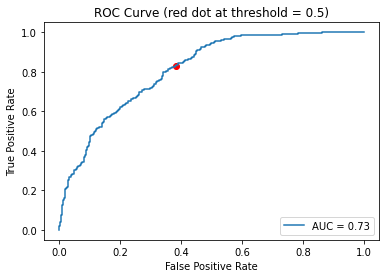

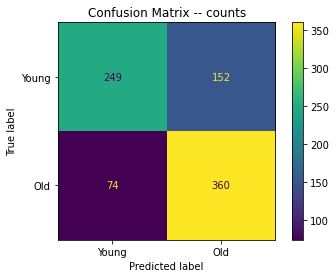

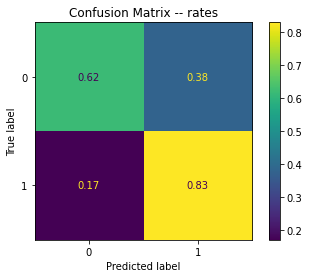

In [ ]:
res = plot_metrics(three_layer_encoded_l2_model, device, dataloaders, phase='test')

### Dropout

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

# model architecture
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2
dropout = .25

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Simple three-hidden-layer classification model with dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Reset the model with dropout
three_layer_encoded_l2_dropout_model = SimpleClassifier3LayerDropout(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes, dropout).to(device)
print(three_layer_encoded_l2_dropout_model)

SimpleClassifier3LayerDropout(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
# By adding a weight_decay term to the optimizer, we are including L2 Regularization!
optimizer = torch.optim.Adam(three_layer_encoded_l2_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_dropout_model, training_curves_three_layer_encoded_l2_dropout = train_model(three_layer_encoded_l2_dropout_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5554 Acc: 0.7127
val   Loss: 0.4603 Acc: 0.7775
test  Loss: 0.5233 Acc: 0.7210

Epoch 2/50
----------
train Loss: 0.5216 Acc: 0.7458
val   Loss: 0.4589 Acc: 0.7823
test  Loss: 0.5215 Acc: 0.7281

Epoch 3/50
----------
train Loss: 0.5229 Acc: 0.7394
val   Loss: 0.4572 Acc: 0.7871
test  Loss: 0.5195 Acc: 0.7257

Epoch 4/50
----------
train Loss: 0.5178 Acc: 0.7454
val   Loss: 0.4597 Acc: 0.7835
test  Loss: 0.5206 Acc: 0.7293

Epoch 5/50
----------
train Loss: 0.5174 Acc: 0.7442
val   Loss: 0.4619 Acc: 0.7931
test  Loss: 0.5200 Acc: 0.7246

Epoch 6/50
----------
train Loss: 0.5198 Acc: 0.7462
val   Loss: 0.4608 Acc: 0.7919
test  Loss: 0.5199 Acc: 0.7246

Epoch 7/50
----------
train Loss: 0.5143 Acc: 0.7434
val   Loss: 0.4572 Acc: 0.7883
test  Loss: 0.5181 Acc: 0.7281

Epoch 8/50
----------
train Loss: 0.5124 Acc: 0.7458
val   Loss: 0.4536 Acc: 0.7871
test  Loss: 0.5170 Acc: 0.7281

Epoch 9/50
----------
train Loss: 0.5115 Acc: 0.7442
val   Loss: 0.4570

In this case, including dropout seemed to only make a little change in our overall accuracy. Considering this is a relatively simple deep model (especially compared to some of the Vision focused nets we will be seeing in the future), this is not entirely unexpected and dropout may not be the best choice for this problem. However let's investigate the training curves below.

#### Training Curves and Metrics

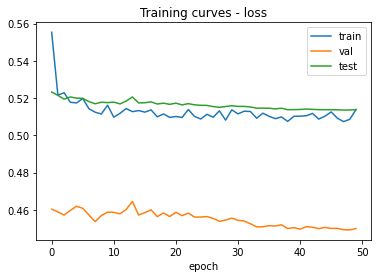

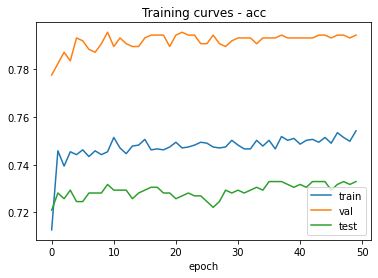

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2_dropout, phases=['train', 'val', 'test'])

Looking at these curves, we can see that including dropout improved the generalization of our model and kept us from overfitting!


At default threshold:
 TN =   244,  FP =   157 -> N =   401
 FN =    67,  TP =   367 -> P =   434
TNR = 0.608, FPR = 0.392
FNR = 0.154, TPR = 0.846
ACC =  0.732


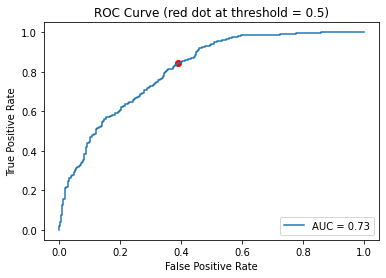

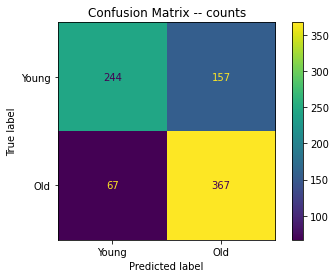

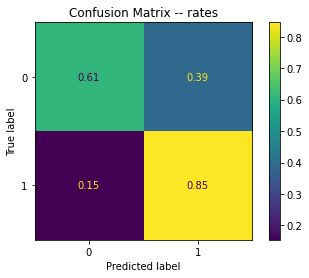

In [ ]:
res = plot_metrics(three_layer_encoded_l2_dropout_model, device, dataloaders, phase='test')

## Regression Model

Now instead of just doing a binary classification on whether an abalone is young or old - we want to predict the exact number of rings! We can easily adapt our model to perform this regression task instead!

### Dataset Preparation

In [ ]:
regression_label_column = 'Rings' # just switch the label column!
# Rings needs to be float as well, otherwise our Loss Function won't work
encoded_df[regression_label_column] = encoded_df[regression_label_column].astype('float32')
encoded_df.dtypes

Sex                object
I                   int64
F                   int64
M                   int64
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weights     float64
Rings             float32
Old                 int64
dtype: object

### Train-Validation-Test Split and Standardization

In [ ]:
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

regression_train_dataset, regression_test_dataset, regression_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, regression_label_column, ct)

### Model Hyperparameters and Definition

In [ ]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

# model architecture
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
output_neurons = 1
dropout = .25

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Simple three-hidden-layer regression model with dropout
class SimpleRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout):
        super(SimpleRegressor, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, output_neurons),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
regression_model = SimpleRegressor(input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout).to(device)
print(regression_model)

SimpleRegressor(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Final Data Preparation

In [ ]:
# Set up pytorch Datasets and DataLoaders

dataloaders = {'train': DataLoader(regression_train_dataset, batch_size=batch_size),
               'val': DataLoader(regression_val_dataset, batch_size=batch_size),
               'test': DataLoader(regression_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(regression_train_dataset),
                 'val': len(regression_val_dataset),
                 'test': len(regression_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


### Training the Model

We will augment the training procedure from before to now fit our regression problem

In [ ]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_regression_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device) #

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.flatten(model(inputs))
                    loss = criterion(outputs, targets)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
# loss and optimizer
criterion = nn.MSELoss() # MSE Loss instead of CrossEntropy
optimizer = torch.optim.Adam(regression_model.parameters(), lr=learning_rate,
                             weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

regression_model, training_curves_regression = train_regression_model(regression_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 26.4749
val   Loss: 6.6037
test  Loss: 5.9042

Epoch 2/50
----------
train Loss: 12.8369
val   Loss: 6.7384
test  Loss: 5.6014

Epoch 3/50
----------
train Loss: 10.9643
val   Loss: 6.4257
test  Loss: 5.5533

Epoch 4/50
----------
train Loss: 10.3306
val   Loss: 6.4179
test  Loss: 5.8504

Epoch 5/50
----------
train Loss: 9.1954
val   Loss: 6.2432
test  Loss: 5.6240

Epoch 6/50
----------
train Loss: 9.1867
val   Loss: 6.3400
test  Loss: 5.5162

Epoch 7/50
----------
train Loss: 8.9495
val   Loss: 6.3010
test  Loss: 5.4210

Epoch 8/50
----------
train Loss: 8.6923
val   Loss: 6.3305
test  Loss: 5.4874

Epoch 9/50
----------
train Loss: 8.6214
val   Loss: 6.2656
test  Loss: 5.5767

Epoch 10/50
----------
train Loss: 8.6131
val   Loss: 6.3528
test  Loss: 5.3939

Epoch 11/50
----------
train Loss: 8.4955
val   Loss: 6.2509
test  Loss: 5.4654

Epoch 12/50
----------
train Loss: 8.2899
val   Loss: 6.2406
test  Loss: 5.4397

Epoch 13/50
----------
train Los

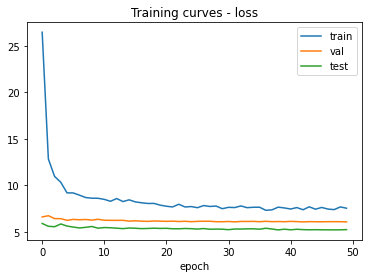

In [ ]:
plot_training_curves(training_curves_regression, metrics=['loss'])

In [ ]:
predicted_ages, true_ages = regress_predictions(regression_model, device, dataloaders['train'])
# You can see that our predictions look sensible compared to the abalone ages!

In [ ]:
predicted_ages

tensor([[10.7833],
        [ 7.5867],
        [11.2583],
        ...,
        [ 8.6376],
        [10.9198],
        [ 8.1794]])

In [ ]:
true_ages

tensor([10.,  9.,  9.,  ...,  7., 14., 10.])

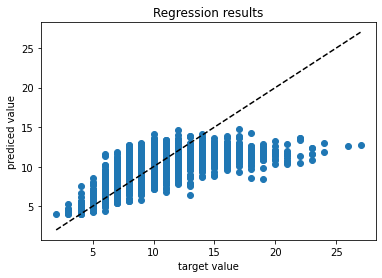

In [ ]:
# Train Results
plot_regression(regression_model, device, dataloaders['train'])

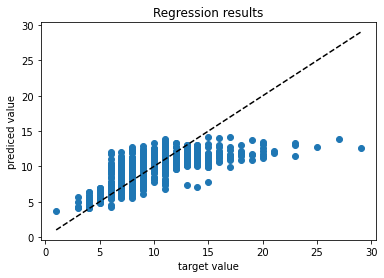

In [ ]:
# Validation Results
plot_regression(regression_model, device, dataloaders['val'])

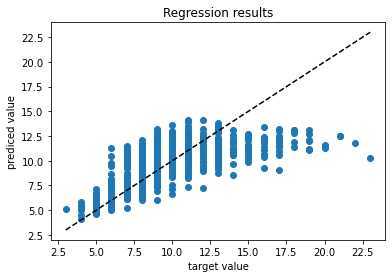

In [ ]:
# Test Results
plot_regression(regression_model, device, dataloaders['test'])

### Looking Ahead

Now that we have built a foundation in PyTorch, we will be able to perform many different machine learning tasks. We will first look to handwritten digit recognition using the MNIST dataset and use that dataset to introduce more complex Deep Neural Network architectures!